In [111]:
import cv2
import os
import matplotlib.pyplot as plt
import torch.utils.data as utils
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from torchvision.utils import save_image

In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [3]:
images_synthetic = load_images_from_folder("./cvidea/validation_cvedia/Data")

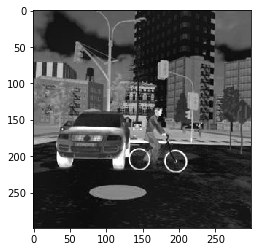

In [4]:
plt.imshow(images_synthetic[3])

In [5]:
images_real = load_images_from_folder("./cvidea/validation_flir/PreviewData")

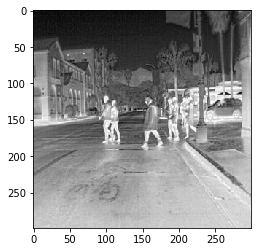

In [6]:
plt.imshow(images_real[3])

In [7]:
images_real[0].shape

(299, 299, 3)

In [8]:
images_real = [i.reshape(3,299,299) for i in images_real]
images_synthetic = [i.reshape(3,299,299) for i in images_synthetic]

In [9]:
images_real = [i/255.0 for i in images_real]
images_synthetic = [i/255.0 for i in images_synthetic]

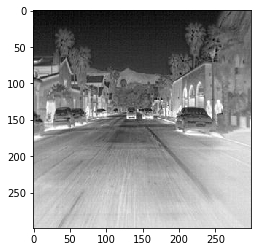

In [10]:
plt.imshow(images_real[0].reshape(299,299,3))

In [11]:
images_real = np.array(images_real)
images_synthetic = np.array(images_synthetic)

In [12]:
tensor_real = torch.stack([torch.Tensor(i) for i in images_real])
tensor_synthetic = torch.stack([torch.Tensor(i) for i in images_synthetic])

In [13]:
dataset_real = utils.TensorDataset(tensor_real)
dataset_synthetic = utils.TensorDataset(tensor_synthetic)

In [14]:
dataloader_real = utils.DataLoader(dataset_real, batch_size=8, shuffle=True)
dataloader_synthetic = utils.DataLoader(dataset_synthetic, batch_size=8, shuffle=True)

In [15]:
for i in dataloader_real:
    break

In [16]:
i[0][0].shape

torch.Size([3, 299, 299])

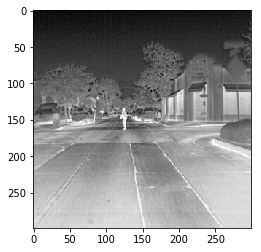

In [17]:
plt.imshow(i[0][0].numpy().reshape(299,299,3))

In [105]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 2, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [106]:
model = autoencoder()

In [107]:
criterion = nn.MSELoss()

In [108]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,
                             weight_decay=1e-5)
num_epochs = 100

In [109]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 299, 299)
    return x

In [112]:
for epoch in range(num_epochs):
    for data in dataloader_real:
        img = data[0]
        img = Variable(img)
        
        output = model(img)
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './ae_out_real/image_{}.png'.format(epoch))
        save_image(img, './ae_out_real/image_{}_actual.png'.format(epoch))

/home/greatskull/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/100], loss:0.0152
epoch [2/100], loss:0.0203
epoch [3/100], loss:0.0158
epoch [4/100], loss:0.0128
epoch [5/100], loss:0.0127
epoch [6/100], loss:0.0161
epoch [7/100], loss:0.0141
epoch [8/100], loss:0.0162
epoch [9/100], loss:0.0102
epoch [10/100], loss:0.0104
epoch [11/100], loss:0.0106
epoch [12/100], loss:0.0156
epoch [13/100], loss:0.0067
epoch [14/100], loss:0.0095
epoch [15/100], loss:0.0123
epoch [16/100], loss:0.0163
epoch [17/100], loss:0.0095
epoch [18/100], loss:0.0136
epoch [19/100], loss:0.0102
epoch [20/100], loss:0.0116
epoch [21/100], loss:0.0137
epoch [22/100], loss:0.0136
epoch [23/100], loss:0.0091
epoch [24/100], loss:0.0084
epoch [25/100], loss:0.0095
epoch [26/100], loss:0.0081
epoch [27/100], loss:0.0082
epoch [28/100], loss:0.0098
epoch [29/100], loss:0.0068
epoch [30/100], loss:0.0070
epoch [31/100], loss:0.0072
epoch [32/100], loss:0.0096
epoch [33/100], loss:0.0057
epoch [34/100], loss:0.0081
epoch [35/100], loss:0.0093
epoch [36/100], loss:0.0067
e

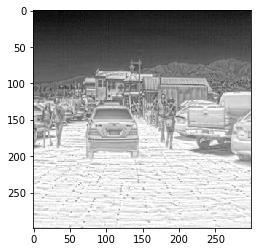

In [119]:
plt.imshow(img[0].numpy().reshape(299,299,3))

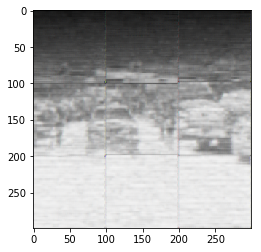

In [129]:
plt.imshow(output[0].detach().numpy().reshape(299,299,3))

In [130]:
torch.save(model.state_dict(), './conv_autoencoder_real.pth')

In [131]:
for epoch in range(num_epochs):
    for data in dataloader_synthetic:
        img = data[0]
        img = Variable(img)
        
        output = model(img)
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './ae_out_real/image_{}.png'.format(epoch))
        save_image(img, './ae_out_real/image_{}_actual.png'.format(epoch))
torch.save(model.state_dict(), './conv_autoencoder_synthetic.pth')

/home/greatskull/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/100], loss:0.0091
epoch [2/100], loss:0.0080
epoch [3/100], loss:0.0066
epoch [4/100], loss:0.0053
epoch [5/100], loss:0.0039
epoch [6/100], loss:0.0035
epoch [7/100], loss:0.0064
epoch [8/100], loss:0.0065
epoch [9/100], loss:0.0045
epoch [10/100], loss:0.0048
epoch [11/100], loss:0.0072
epoch [12/100], loss:0.0050
epoch [13/100], loss:0.0060
epoch [14/100], loss:0.0042
epoch [15/100], loss:0.0077
epoch [16/100], loss:0.0046
epoch [17/100], loss:0.0062
epoch [18/100], loss:0.0063
epoch [19/100], loss:0.0059
epoch [20/100], loss:0.0055
epoch [21/100], loss:0.0058
epoch [22/100], loss:0.0055
epoch [23/100], loss:0.0071
epoch [24/100], loss:0.0096
epoch [25/100], loss:0.0049
epoch [26/100], loss:0.0043
epoch [27/100], loss:0.0049
epoch [28/100], loss:0.0050
epoch [29/100], loss:0.0058
epoch [30/100], loss:0.0057
epoch [31/100], loss:0.0054
epoch [32/100], loss:0.0055
epoch [33/100], loss:0.0074
epoch [34/100], loss:0.0042
epoch [35/100], loss:0.0044
epoch [36/100], loss:0.0060
e

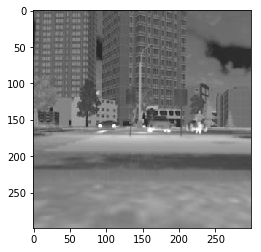

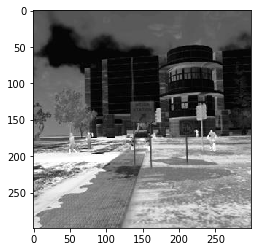

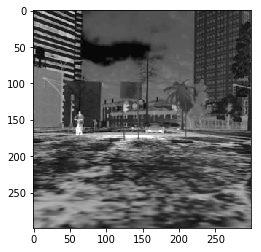

In [139]:
for i in range(3):
    plt.imshow(img[i].numpy().reshape(299,299,3))
    plt.show()

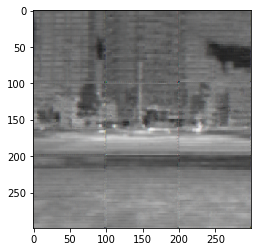

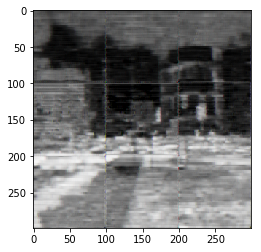

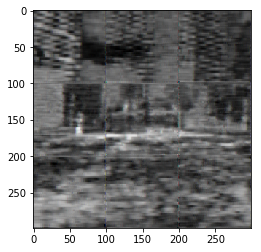

In [140]:
for i in range(3):
    plt.imshow(output[i].detach().numpy().reshape(299,299,3))
    plt.show()